#Tercer intento#



*   Solo con los datos de Madrid de Idealista2018
*   Madrid_Sale.csv y Madrid_Polygons.rda bajados de https://github.com/paezha/idealista18/tree/e2cfe3f621e1c37f226ce956f61b7306c42d5721/data


*   archivo Madrid_Polygons.rda transformado en csv con Notebook en R Script R rda a csv.ipyn https://colab.research.google.com/drive/1I06zwKUreseL1p87dHq0TzMheUHiEmVc


*   Exploración de datos (EDA) copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb
*Agregar la Columna neighbourhood a df_Madrid: de la latitud y longitud de cada casa se busca el barrio al que corresponde en Madrid_Polygons.csv

* la variable que vamos intentar predecir va a ser la diferencia en % entre el precio del piso y el precio medio por barrio - usaremos solo los datos del cuarto trimestre, quitando los que la diferencia sea mayor del 100%

* se usan varios modelos, y luego se calcula el error en el precio





In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
file_path = '/content/drive/My Drive/Idealista_2024/datos_2018/'

Mounted at /content/drive


In [2]:
from getpass import getpass
import os

# Solicita el token personal de GitHub
token = getpass('GitHub Token: ')

# Define la URL del repositorio y la ruta de clonación
repo_url = "https://github.com/edouardor/Idealista_2024.git"
destino = "/content/drive/MyDrive/Idealista_2024"

# Clona el repositorio en la carpeta de Google Drive
os.system(f'git clone https://{token}@github.com/edouardor/Idealista_2024.git {destino}')


GitHub Token: ··········


32768

In [3]:
%cd /content/drive/MyDrive/Idealista_2024

/content/drive/MyDrive/Idealista_2024


In [4]:
!ls -a


catboost_info  datos_2024  .ipynb_checkpoints  Notebooks
datos_2018     .git	   Madrid_Sale.pdf     README.md


In [5]:
!git config --global user.email "edouardo@hotmail.es"
!git config --global user.name "edouardor"

In [ ]:
# Mostrar la rama actual
!git branch


In [70]:
# Crear y cambiar a una nueva rama
#!git checkout -b rama-limpia

# Agregar los archivos modificados
!git add .

# Hacer un commit
!git commit -m "Cambios realizados desde Google Colab en nueva rama - notebook limpiado"

# Subir la nueva rama al remoto
!git push -u origin rama-limpia


[rama-limpia 6bd5663] Cambios realizados desde Google Colab en nueva rama - notebook limpiado
 5 files changed, 4507 insertions(+), 1 deletion(-)
 rewrite Notebooks/Idealista Madrid github.ipynb (84%)
 create mode 100644 catboost_info/catboost_training.json
 create mode 100644 catboost_info/learn/events.out.tfevents
 create mode 100644 catboost_info/learn_error.tsv
 create mode 100644 catboost_info/time_left.tsv
Enumerating objects: 13, done.
Counting objects: 100% (13/13), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (10/10), 408.40 KiB | 5.24 MiB/s, done.
Total 10 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/edouardor/Idealista_2024.git
   4bc8242..6bd5663  rama-limpia -> rama-limpia
Branch 'rama-limpia' set up to track remote branch 'rama-limpia' from 'origin'.


In [71]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_columns', None)

## Initializing Datasets

###Solo Madrid


In [72]:

df= pd.read_csv(file_path+'gdf_Madrid_with_metro_count.csv')


In [73]:
gdf = pd.read_csv(file_path+'Madrid_Polygons_with_mean_unitprice.csv')

*para poner luego los clusters definidos para cada barrio*

In [74]:
df.head(3)

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,Hellín,2
1,A8841356095019025740,3,133000,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,Hellín,1
2,A6716251930495709236,3,98000,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,Hellín,1


## Exploratory Data Analysis

In [75]:
print(df.dtypes)

ASSETID                     object
PERIOD                       int64
PRICE                        int64
UNITPRICE                  float64
ADTYPOLOGYID                object
ADOPERATIONID               object
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
AMENITYID                    int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR 

From here we can observe that the formatted variable types make sense with the expected and are homogeneous among the different datasets.

In [76]:
df.describe(include='all')

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
count,75740,75740.000000,7.574000e+04,75740.000000,75740,75740,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740,75740,75740,75740,75740.000000
unique,75740,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,135,NaN
top,A2624736749193113090,NaN,NaN,NaN,HOME,SALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,HOME,SALE,Lavapiés-Embajadores,NaN
freq,1,NaN,NaN,NaN,75740,75740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75740,75740,75740,2947,NaN
mean,NaN,2.784500,3.885028e+05,3632.521702,NaN,NaN,100.217586,2.570148,1.570240,0.351149,0.689213,0.439041,2.924835,0.216794,0.104383,0.231344,0.196343,0.142831,0.249908,0.563982,0.141907,0.247320,0.176657,0.025297,0.027079,0.021495,2.714840,0.871283,1965.446409,6.360536,38.695801,4.870399,0.031780,0.186903,0.781318,4.474552,0.469338,2.675121,-3.686323,40.420673,NaN,NaN,NaN,NaN,1.457182
std,NaN,1.209515,4.124885e+05,1708.417808,NaN,NaN,66.433670,1.246913,0.835428,0.477332,0.462819,0.496273,0.313232,0.412064,0.305759,0.421695,0.397233,0.349902,0.432962,0.495893,0.348957,0.431457,0.381381,0.157027,0.162316,0.145027,2.211571,0.334888,28.916426,2.843000,53.290795,1.460220,0.175414,0.389836,0.413355,2.669527,0.593230,2.199341,0.038916,0.033458,NaN,NaN,NaN,NaN,1.314439
min,NaN,1.000000,2.100000e+04,805.309734,NaN,NaN,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1623.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.007647,0.001416,0.001435,-3.832534,40.328682,NaN,NaN,NaN,NaN,0.000000
25%,NaN,2.000000,1.570000e+05,2200.000000,NaN,NaN,62.000000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1955.000000,5.000000,12.000000,4.000000,0.000000,0.000000,1.000000,2.401815,0.212906,1.040583,-3.708313,40.396519,NaN,NaN,NaN,NaN,0.000000
50%,NaN,3.000000,2.560000e+05,3440.000000,NaN,NaN,82.000000,3.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1967.000000,6.000000,21.000000,5.000000,0.000000,0.000000,1.000000,4.112561,0.329996,1.961970,-3.694002,40.423025,NaN,NaN,NaN,NaN,1.000000
75%,NaN,4.000000,4.560000e+05,4719.558389,NaN,NaN,115.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1983.000000,8.000000,39.000000,6.000000,0.000000,0.000

In [77]:
# prompt: drop observertions where df[df['ROOMNUMBER']>20]
print(f"Hay {len(df[df['ROOMNUMBER']>20])} pisos con mas de 20 habitaciones")
print("los quitamos")

df = df[df['ROOMNUMBER'] <= 20]

Hay 2 pisos con mas de 20 habitaciones
los quitamos


In [78]:
# dime cuales son los valores medios de UNITPRICE para cada periodo, y la diferencia en % con el primer periodo - con dos decimales es suficiente - pon tambien cuantos datos hay en df para cada periodo


# Group data by 'PERIOD' and calculate the mean of 'UNITPRICE'
mean_unitprice_by_period = df.groupby('PERIOD')['UNITPRICE'].agg(['mean', 'count'])

# Calculate the percentage difference from the first period
first_period_mean = mean_unitprice_by_period['mean'].iloc[0]
mean_unitprice_by_period['pct_change'] = ((mean_unitprice_by_period['mean'] - first_period_mean) / first_period_mean) * 100

# Format the output
mean_unitprice_by_period['pct_change'] = mean_unitprice_by_period['pct_change'].round(2)
mean_unitprice_by_period = mean_unitprice_by_period.rename(columns={'mean':'mean_unitprice', 'count':'n_datapoints'})

mean_unitprice_by_period

,mean_unitprice,n_datapoints,pct_change
PERIOD,,,
1,3478.870144,17603,0.00
2,3567.903365,12507,2.56
3,3646.436186,14234,4.82
4,3738.182770,31394,7.45


In [79]:
df.loc[:, 'Precio_medio_m2'] = df.groupby(['neighbourhood', 'PERIOD'])['UNITPRICE'].transform('mean')


In [80]:
df.head(3)

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m,Precio_medio_m2
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,Hellín,2,1898.550087
1,A8841356095019025740,3,133000,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,Hellín,1,1760.246263
2,A6716251930495709236,3,98000,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,Hellín,1,1760.246263


###El valor a predecir va a ser la diferencia en % entre el precio por m2 del piso y el precio por m2 del barrio en el que se encuentra

In [81]:
# prompt: pon una columna con (UNITPRICE - Precio_medio_m2)/Precio_medio_m2

# Calculate the new column
df['diferencia_precio_m2'] = (df['UNITPRICE'] - df['Precio_medio_m2']) / df['Precio_medio_m2']

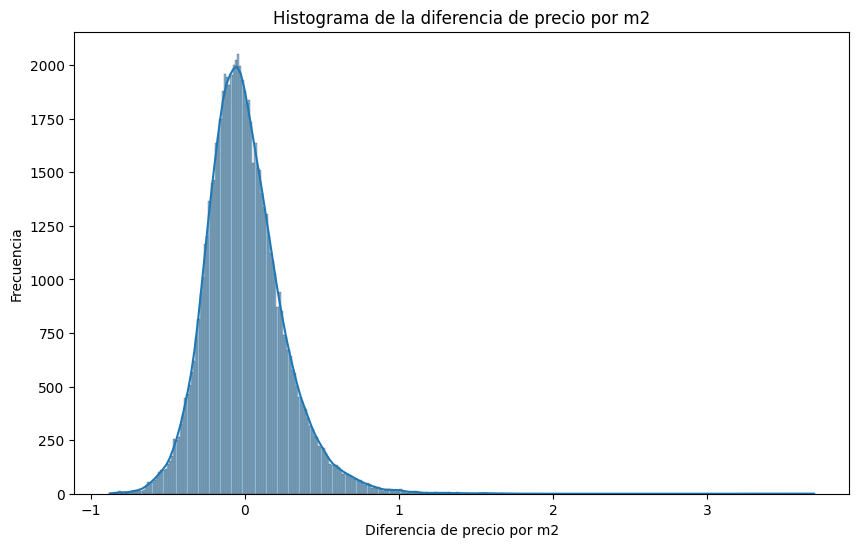

In [82]:
# prompt: haz un histograma con diferencia_precio_m2

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['diferencia_precio_m2'], kde=True)
plt.title('Histograma de la diferencia de precio por m2')
plt.xlabel('Diferencia de precio por m2')
plt.ylabel('Frecuencia')
plt.show()

In [83]:
# prompt: dime cuantos valores hay superiores a 1

# Assuming 'df' is your DataFrame and it has a column named 'diferencia_precio_m2'
count_greater_than_1 = len(df[df['diferencia_precio_m2'] > 1])
print(f"Hay {count_greater_than_1} valores superiores a 1 en la columna 'diferencia_precio_m2'.")
df = df[df['diferencia_precio_m2'] <= 1]
print("los quitamos")


Hay 240 valores superiores a 1 en la columna 'diferencia_precio_m2'.
los quitamos


In [84]:
# Calcular los percentiles para el 1% inferior y superior
lower_bound = df['PRICE'].quantile(0.01)  # 1% inferior
upper_bound = df['PRICE'].quantile(0.99)  # 1% superior

formatted_lower_bound = "{:,.0f}".format(lower_bound)
formatted_upper_bound = "{:,.0f}".format(upper_bound)

print(f"Vamos a quitar los pisos con un precio inferior a {formatted_lower_bound} euros")
print(f"y los que tengan un precio superior a {formatted_upper_bound} euros")

pisos_inicial = len(df)
print(f"Hay {pisos_inicial} pisos en total")

# Filtrar el DataFrame para conservar solo el 99% de los datos
df= df[(df['PRICE'] >= lower_bound) & (df['PRICE'] <= upper_bound)]

# Calculate the number of rows removed
removed_rows = pisos_inicial - len(df)

print(f"Hemos quitado {removed_rows} pisos")

print(f"Quedan {len(df)} pisos")

Vamos a quitar los pisos con un precio inferior a 69,000 euros
y los que tengan un precio superior a 2,179,090 euros
Hay 75498 pisos en total
Hemos quitado 1445 pisos
Quedan 74053 pisos


El primer predictor posible del precio es el precio medio del m2 por barrio y periodo múltiplicado por los m2.

Vamos a calcular cuanto sería el error medio en valor absoluto que cometemos así, y esto nos servirá como escenario base que mejorar.

In [85]:
# prompt: cual es el error (Mape) entre PRICE y CONSTRUCTEDAREA * Precio_medio_m2 ?

# Calculate the predicted price based on CONSTRUCTEDAREA and Precio_medio_m2
df['predicted_price'] = df['CONSTRUCTEDAREA'] * df['Precio_medio_m2']

# Calculate the Mean Absolute Percentage Error (MAPE)
df['percentage_error'] = abs((df['PRICE'] - df['predicted_price']) / df['PRICE']) * 100

mape = df['percentage_error'].mean()

print(f"El MAPE entre PRICE y CONSTRUCTEDAREA * Precio_medio_m2 es: {mape:.2f}%")

El MAPE entre PRICE y CONSTRUCTEDAREA * Precio_medio_m2 es: 20.62%


## Multivariate Analysis

Vamos a agrupar los diferentes barrios en clusters, de barrios 'baratos' a barrios caros.

Para evitar problemas, vamos a usar solo los datos del cuarto trimestre.


In [86]:
df4 = df[df['PERIOD'] == 4]

**Determinamos el Número Óptimo de Grupos**

*Antes de realizar la agrupación, es útil determinar cuántos grupos (clusters) son apropiados. Una técnica común para esto es el método del codo.*

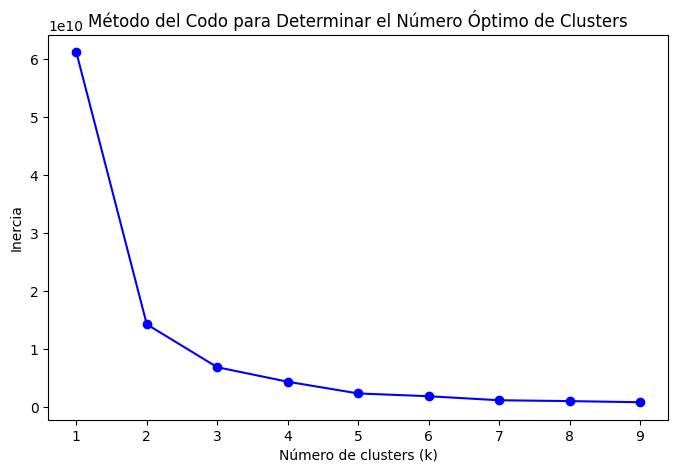

In [87]:
from sklearn.cluster import KMeans

# Lista para almacenar la inercia
inercia = []
K = range(1, 10)

for k in K:
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(df4[['Precio_medio_m2']])
    inercia.append(modelo.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inercia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.show()


*Buscamos un "codo" en la gráfica donde la inercia comienza a disminuir de manera menos pronunciada. Aquí k=6*

**Aplicar K-Means para Agrupar los Barrios**

In [88]:
# Definir el número de clusters
k_optimo = 6

# Inicializar y ajustar el modelo
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Precio_medio_m2']])

# Opcional: Añadir los centroides
centroides = kmeans.cluster_centers_


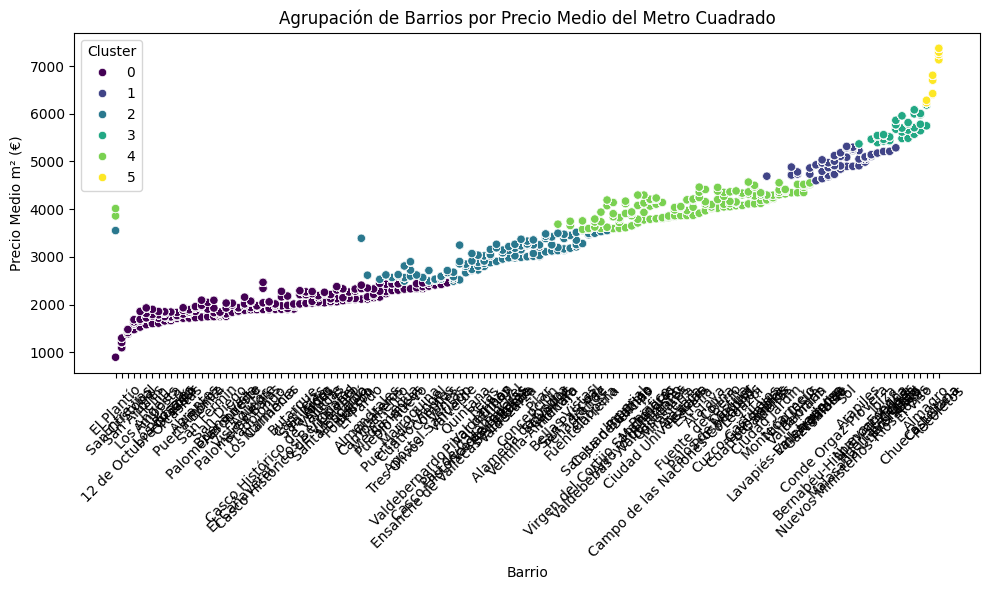

In [89]:
# Ordenar los barrios por precio medio y cluster
df.sort_values('Precio_medio_m2', inplace=True)


# Visualización con Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='neighbourhood', y='Precio_medio_m2', hue='Cluster', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Barrio')
plt.ylabel('Precio Medio m² (€)')
plt.title('Agrupación de Barrios por Precio Medio del Metro Cuadrado')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


**Nos Aseguramos la Consistencia de los Nombres de Barrios entre los ficheros**

In [90]:
df['Cluster'].value_counts()

,count
Cluster,
0,21979
4,18035
2,14163
1,10566
3,7378
5,1932


**Verificamos la Asignación de Clusters**

In [91]:
# Verificar si hay pisos sin asignar a un cluster
pisos_sin_cluster = df[df['Cluster'].isna()]
num_sin_cluster = pisos_sin_cluster.shape[0]

if num_sin_cluster > 0:
    print(f"Hay {num_sin_cluster} pisos sin asignar a un cluster:")
    print(pisos_sin_cluster[['neighbourhood']].drop_duplicates())
else:
    print("Todos los pisos han sido asignados a un cluster.")


Todos los pisos han sido asignados a un cluster.


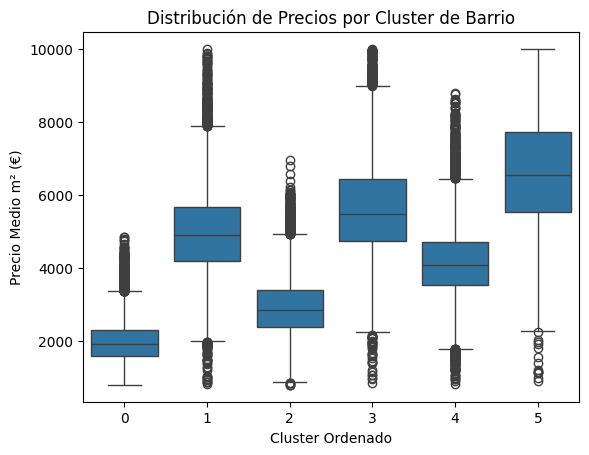

In [92]:
sns.boxplot(data=df, x='Cluster', y='UNITPRICE')

plt.title('Distribución de Precios por Cluster de Barrio')
plt.xlabel('Cluster Ordenado')
plt.ylabel('Precio Medio m² (€)')
plt.show()


## ML Models

In [93]:
df.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
       'HASEASTORIENTATION', 'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE',
       'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO',
       'ISINTOPFLOOR', 'FLOORCLEAN', 'FLATLOCATIONID', 'CADCONSTRUCTIONYEAR',
       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID',
       'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_STREET',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION',
       'neighbourhood', 'metros_within_500m', 'Precio_medio_m2',
       'diferencia_precio_m2', 'predicted_price', 'percentage_error',
       'Cluster'],
      dtype='object')

In [32]:
# prompt: crea una nueva columna llamada BUILTTYPE que valga 1 si BUITTYPEID_1 vale 1, 2 si BUITTYPEID_2 vale 1 y 3 si BUITTYPEID_3 vale 1

# Create the 'BUILTTYPE' column based on the conditions
df['BUILTTYPE'] = 0  # Initialize the column with 0
df.loc[df['BUILTTYPEID_1'] == 1, 'BUILTTYPE'] = 1
df.loc[df['BUILTTYPEID_2'] == 1, 'BUILTTYPE'] = 2
df.loc[df['BUILTTYPEID_3'] == 1, 'BUILTTYPE'] = 3

In [94]:

madrid = df.drop(columns=['ASSETID','PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID','AMENITYID','HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
       'HASEASTORIENTATION', 'HASWESTORIENTATION','FLATLOCATIONID',
       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID','DISTANCE_TO_METRO',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION',
       'neighbourhood', 'metros_within_500m','BUILTTYPEID_1','BUILTTYPEID_2','BUILTTYPEID_3','DISTANCE_TO_CITY_CENTER','predicted_price', 'percentage_error'])

In [95]:
madrid.columns

Index(['PERIOD', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE',
       'HASLIFT', 'HASAIRCONDITIONING', 'HASPARKINGSPACE', 'HASBOXROOM',
       'HASWARDROBE', 'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX',
       'ISSTUDIO', 'ISINTOPFLOOR', 'FLOORCLEAN', 'CADCONSTRUCTIONYEAR',
       'DISTANCE_TO_STREET', 'Precio_medio_m2', 'diferencia_precio_m2',
       'Cluster'],
      dtype='object')

In [96]:
madrid = madrid[madrid['PERIOD']==4]
madrid.drop(columns=['PERIOD'], inplace=True)

<ipython-input-96-161a1c937880>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madrid.drop(columns=['PERIOD'], inplace=True)


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import statsmodels.api as sm

X = madrid.drop(['diferencia_precio_m2'], axis=1)
y = madrid['diferencia_precio_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [98]:
y_test.shape

(6155,)

In [39]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()

y_pred = model_sm.predict(X_test_sm)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(model_sm.summary())

MAE: 0.1570598283313053
MDAE: 0.12483742889366561
RMSE: 0.20683035406937342
MAPE: 298.3061766191756%
                             OLS Regression Results                             
Dep. Variable:     diferencia_precio_m2   R-squared:                       0.221
Model:                              OLS   Adj. R-squared:                  0.221
Method:                   Least Squares   F-statistic:                     349.3
Date:                  Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                          08:46:23   Log-Likelihood:                 3646.3
No. Observations:                 24616   AIC:                            -7251.
Df Residuals:                     24595   BIC:                            -7080.
Df Model:                            20                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-

In [99]:
# prompt: define una función con X_test y y_pred como input, y MAE, MSE, Medae y mape como output

import numpy as np
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

def calculate_metrics(X_test, y_pred, y_test):
    """
    Calculates MAE, MSE, MedAE, and MAPE.

    Args:
        X_test: Test features (not used in the calculations, but included for consistency with the original code).
        y_pred: Predicted values.
        y_test: True values.

    Returns:
        A dictionary containing MAE, MSE, MedAE, and MAPE.
    """
    indices_test = X_test.index
    price_test = df.loc[indices_test, 'UNITPRICE'] * df.loc[indices_test, 'CONSTRUCTEDAREA']

    unitprice_pred = (1 + y_pred)  * X_test['Precio_medio_m2']
    price_pred = unitprice_pred * X_test['CONSTRUCTEDAREA']

    mae = mean_absolute_error(price_test, price_pred)
    mse = mean_squared_error(price_test, price_pred)
    medae = median_absolute_error(price_test, price_pred)
    mape = np.mean(np.abs((price_test- price_pred) / price_test)) * 100

    return {'mae': mae, 'mse': mse, 'medae': medae, 'mape': mape}

In [106]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 3. Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 4. Realizar predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)


# imprimir error medio en precios, en %
error_medio_precios = calculate_metrics(X_test, y_pred, y_test)['mape']
print(f'Error medio en precios con regresión lineal: {error_medio_precios:.2f}%')


Error medio en precios con regresión lineal: 16.77%


In [ ]:
import shap

# Crear un objeto explainer
explainer = shap.Explainer(modelo, X_train)
shap_values = explainer(X_test)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_test)


*Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}*

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
                Feature  Importance
0       CONSTRUCTEDAREA    0.194105
17   DISTANCE_TO_STREET    0.164203
18      Precio_medio_m2    0.135003
16  CADCONSTRUCTIONYEAR    0.121022
15           FLOORCLEAN    0.085843
1            ROOMNUMBER    0.057911
4               HASLIFT    0.051613
9       HASSWIMMINGPOOL    0.029052
2            BATHNUMBER    0.025645
5    HASAIRCONDITIONING    0.021808
19              Cluster    0.019263
6       HASPARKINGSPACE    0.018135
8           HASWARDROBE    0.016690
3            HASTERRACE    0.015496
7            HASBOXROOM    0.012688
10           HASDOORMAN    0.010711
11            HASGARDEN    0.008240
14         ISINTOPFLOOR    0.005293
12             ISDUPLEX    0.004323
13             ISSTUDIO    0.002957


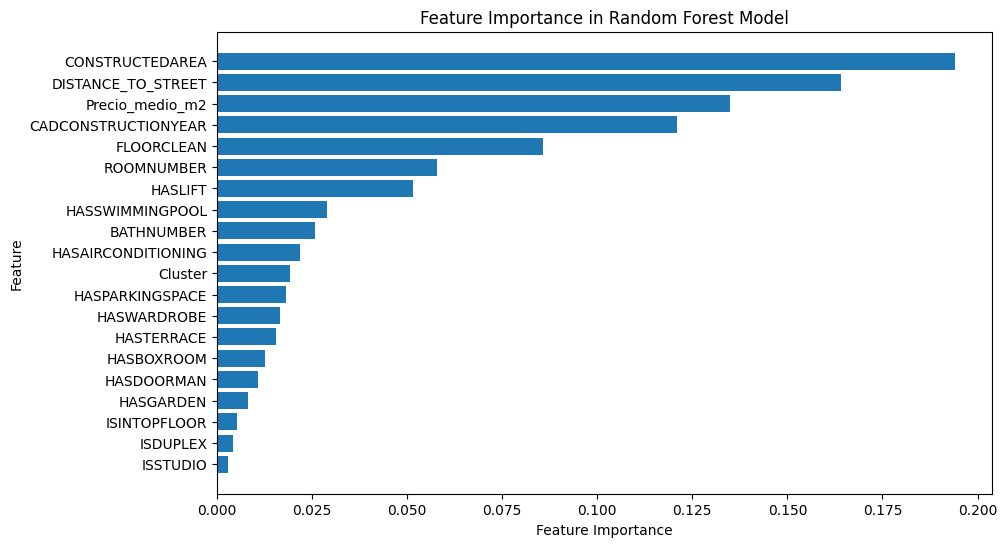

In [107]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
#import matplotlib.pyplot as plt


rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300]
    'max_depth': [None], #[10, 20, None]
    'min_samples_split': [2], #[2, 5, 10]
    'min_samples_leaf': [1], #[1, 2, 4]
    'bootstrap': [True] #[True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)


print(f'Best parameters found: {grid_search.best_params_}')

feature_importances = best_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [108]:
# imprimir error medio en precios, en %
error_medio_precios = calculate_metrics(X_test, y_pred, y_test)['mape']
print(f'Error medio en precios con random forest: {error_medio_precios:.2f}%')

Error medio en precios con random forest: 13.22%


*Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1.0}*


In [101]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300],
    'max_depth': [10], #[3, 5, 7, 10],
    'learning_rate':  [0.05], #[0.01, 0.05, 0.1, 0.2]
    'subsample': [1], #[0.6, 0.8, 1.0],
    'colsample_bytree':[0.6], #[0.6, 0.8, 1.0],
    'reg_alpha': [0.1], #[0, 0.1, 0.5, 1],
    'reg_lambda': [0], #[0, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=xgb, n_jobs=-1, param_grid=param_grid, cv=5, verbose=10, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

print(f'Best parameters found: {grid_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1}


In [102]:
# imprimir error medio en precios, en %
error_medio_precios = calculate_metrics(X_test, y_pred, y_test)['mape']
print(f'Error medio en precios con xgboost: {error_medio_precios:.2f}%')

Error medio en precios con xgboost: 12.98%


In [103]:
# Solo si deseas verificar (no recomendado para evaluar rendimiento)
y_pred_all = best_xgb.predict(X)
error_medio_precios = calculate_metrics(X, y_pred_all, y)['mape']
print(f'Error medio en precios totales con xgboost: {error_medio_precios:.2f}%')

Error medio en precios totales con xgboost: 8.09%


In [104]:
!pip install catboost
from catboost import CatBoostRegressor

In [105]:

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1500,  # Adjust as needed
                                   learning_rate=0.1,  # Adjust as needed
                                   depth=9,  # Adjust as needed
                                   loss_function='RMSE',  # Or another appropriate loss function
                                   random_seed=42,
                                   verbose=100) # Set verbose for progress updates

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred_catboost = catboost_model.predict(X_test)

# Calculate metrics
error_medio_precios_catboost = calculate_metrics(X_test, y_pred_catboost, y_test)['mape']
print(f'Error medio en precios con CatBoost: {error_medio_precios_catboost:.2f}%')

0:	learn: 0.2307882	total: 38.6ms	remaining: 57.9s
100:	learn: 0.1724044	total: 2.97s	remaining: 41.1s
200:	learn: 0.1582607	total: 6.72s	remaining: 43.4s
300:	learn: 0.1483839	total: 11.4s	remaining: 45.3s
400:	learn: 0.1414226	total: 14.4s	remaining: 39.4s
500:	learn: 0.1349459	total: 17.6s	remaining: 35s
600:	learn: 0.1290338	total: 20.6s	remaining: 30.8s
700:	learn: 0.1243705	total: 25.6s	remaining: 29.2s
800:	learn: 0.1198661	total: 29.6s	remaining: 25.8s
900:	learn: 0.1154994	total: 32.8s	remaining: 21.8s
1000:	learn: 0.1115578	total: 35.5s	remaining: 17.7s
1100:	learn: 0.1078821	total: 36.9s	remaining: 13.4s
1200:	learn: 0.1045774	total: 39.5s	remaining: 9.84s
1300:	learn: 0.1014228	total: 42.3s	remaining: 6.47s
1400:	learn: 0.0982604	total: 44s	remaining: 3.11s
1499:	learn: 0.0956689	total: 45.4s	remaining: 0us
Error medio en precios con CatBoost: 13.11%
